---

Загружаю необходимые библиотеки

In [323]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

Я предварительно перевел датасет из формата xlsx в csv, увидел, что там будут столбцы формата дата-время, выношу названия столбцов в отдельный список

In [324]:
date_columns = ['time_order','time_offer','time_assign','time_arrive','trip_time']

Загружаю датасет

In [325]:
df = pd.read_csv('datapark.csv', header=0, parse_dates=date_columns, dayfirst=True)
df.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time
0,10001,0,2024-03-04 00:00:01,2024-03-04 00:00:42,2024-03-04 00:01:13,2024-03-04 00:09:07,2024-03-04 01:27:28
1,10002,0,2024-03-04 00:00:22,2024-03-04 00:01:00,2024-03-04 00:01:14,2024-03-04 00:08:45,2024-03-04 00:22:22
2,10003,1,2024-03-04 00:07:08,2024-03-04 00:07:44,NaT,NaT,NaT
3,10004,1,2024-03-04 00:07:11,2024-03-04 00:08:21,2024-03-04 00:08:46,2024-03-04 00:21:13,2024-03-04 01:23:25
4,10005,0,2024-03-04 00:11:59,2024-03-04 00:12:50,2024-03-04 00:13:09,2024-03-04 00:21:43,2024-03-04 00:46:45


Провожу предварительный анализ данных с целью поиска возможных ошибок:  

In [326]:
# 1. Проверяю типы данных в столбцах  
df.dtypes

id_order                int64
test_group              int64
time_order     datetime64[ns]
time_offer     datetime64[ns]
time_assign    datetime64[ns]
time_arrive    datetime64[ns]
trip_time      datetime64[ns]
dtype: object

In [327]:
# 2. Считаю количество Nan в столбцах  
df.isna().sum()

id_order          0
test_group        0
time_order        0
time_offer     1500
time_assign    2657
time_arrive    4557
trip_time      4897
dtype: int64

In [328]:
# 3. Проверяю наличие дубликатов в столбце id_order (мог ли один заказ встретиться несколько раз?)  
df.id_order.duplicated().sum()

0

In [329]:
# 4. Проверяю, что столбец test_group действительно содержит только две группы 1 и 0
df.test_group.unique()

array([0, 1], dtype=int64)

In [330]:
# 5. Проверяю, может ли в данных случиться ошибка, когда после столбца с пустой ячейкой (Nan) 
# встречается столбец с существующим событием (не Nan), то есть имеются пропуски при заполнении данных

mistakes = (df.time_order.isna() & df.time_offer.notna() |
    df.time_offer.isna() & df.time_assign.notna() |
    df.time_assign.isna() & df.time_arrive.notna() |
    df.time_arrive.isna() & df.trip_time.notna())

mistakes.sum()

0

Вывод: все столбцы нужных типов данных, дубликатов или лишних групп не обнаруженно, все этапы в заказах имеют нужный порядок

Хочу выяснить длительность проведения эксперимента

In [331]:
print('Начало ', df.time_order.min(),'\nОкончание', df.time_order.max(),'\nДлительность', df.time_order.max()-df.time_order.min())

Начало  2024-03-04 00:00:01 
Окончание 2024-03-10 23:45:48 
Длительность 6 days 23:45:47


Считаю количество заказов по дням

In [332]:
daily_counts = df.groupby(df.time_order.dt.date).size().reset_index(name='count')
daily_counts.rename(columns={'time_order': 'date'}, inplace=True)
daily_counts

,date,count
0,2024-03-04,1102
1,2024-03-05,1138
2,2024-03-06,1187
3,2024-03-07,1855
4,2024-03-08,3831
5,2024-03-09,1900
6,2024-03-10,1268


Строю график Количество заказов по дням

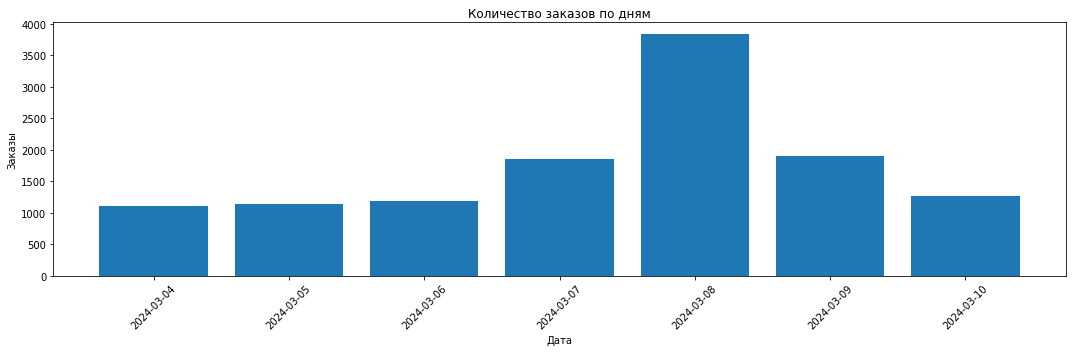

In [333]:
plt.figure(figsize=(15,5))
plt.bar(daily_counts['date'].astype(str), daily_counts['count'])
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.title('Количество заказов по дням')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Вывод: больше всего заказов 3831 пришлось на 2024-03-08, праздничный выходной день

In [334]:
df

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time
0,10001,0,2024-03-04 00:00:01,2024-03-04 00:00:42,2024-03-04 00:01:13,2024-03-04 00:09:07,2024-03-04 01:27:28
1,10002,0,2024-03-04 00:00:22,2024-03-04 00:01:00,2024-03-04 00:01:14,2024-03-04 00:08:45,2024-03-04 00:22:22
2,10003,1,2024-03-04 00:07:08,2024-03-04 00:07:44,NaT,NaT,NaT
3,10004,1,2024-03-04 00:07:11,2024-03-04 00:08:21,2024-03-04 00:08:46,2024-03-04 00:21:13,2024-03-04 01:23:25
4,10005,0,2024-03-04 00:11:59,2024-03-04 00:12:50,2024-03-04 00:13:09,2024-03-04 00:21:43,2024-03-04 00:46:45
...,...,...,...,...,...,...,...
12276,22293,0,2024-03-08 18:45:00,2024-03-08 18:46:21,2024-03-08 18:46:56,NaT,NaT
12277,22294,0,2024-03-08 18:26:51,2024-03-08 18:28:04,2024-03-08 18:28:31,NaT,NaT
12278,22295,1,2024-03-08 18:58:33,2024-03-08 18:59:46,2024-03-08 19:00:23,2024-03-08 19:08:35,2024-03-08 19:22:24
12279,22296,0,2024-03-08 18:47:16,2024-03-08 18:48:49,2024-03-08 18:49:09,2024-03-08 18:53:32,2024-03-08 19:31:03


Я обнаружил странность, что последняя дата заказа в датафрейме не совпадает с датой окончания эксперимента. Сортирую таблицу по времени создания заказа

In [335]:
df.sort_values('time_order')

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time
0,10001,0,2024-03-04 00:00:01,2024-03-04 00:00:42,2024-03-04 00:01:13,2024-03-04 00:09:07,2024-03-04 01:27:28
1,10002,0,2024-03-04 00:00:22,2024-03-04 00:01:00,2024-03-04 00:01:14,2024-03-04 00:08:45,2024-03-04 00:22:22
2,10003,1,2024-03-04 00:07:08,2024-03-04 00:07:44,NaT,NaT,NaT
3,10004,1,2024-03-04 00:07:11,2024-03-04 00:08:21,2024-03-04 00:08:46,2024-03-04 00:21:13,2024-03-04 01:23:25
4,10005,0,2024-03-04 00:11:59,2024-03-04 00:12:50,2024-03-04 00:13:09,2024-03-04 00:21:43,2024-03-04 00:46:45
...,...,...,...,...,...,...,...
11523,21539,0,2024-03-10 23:33:23,2024-03-10 23:33:50,2024-03-10 23:34:18,NaT,NaT
11524,21540,1,2024-03-10 23:38:41,2024-03-10 23:38:57,2024-03-10 23:39:10,2024-03-10 23:44:52,2024-03-11 00:43:37
11525,21541,1,2024-03-10 23:39:40,NaT,NaT,NaT,NaT
11526,21542,1,2024-03-10 23:41:24,2024-03-10 23:42:07,2024-03-10 23:42:40,2024-03-10 23:51:43,2024-03-11 00:05:40


Вывод: номера заказов могут идти не по порядку.  
Хочу выяснить почему так происходит. Расчитываю диапазон имеющихся номеров заказов

In [336]:
print('Номер первого заказа ', df.id_order.min(),'\nНомер последний заказа', df.id_order.max(),'\nРазница', df.id_order.max()-df.id_order.min())

Номер первого заказа  10001 
Номер последний заказа 22297 
Разница 12296


Расчитываю разницу между количеством заказов и диапазоном номеров заказов

In [337]:
abs(df.shape[0]-(df.id_order.max()-df.id_order.min()))

15

Вывод: имеется 15 пропущенных номеров заказов. Скорее всего 15 заказов были удалены из датасета по какой то причине. На ход экперемента это не влияет

Возвращаюсь к проверке порядка заказов. Хочу выяснить сколько заказов нарушают порядок. Для этого считаю разницу между значениями идущими по порядку, между которыми вкрались номера нарушающие порядок

In [338]:
df_sorted = df.sort_values('time_order')

In [339]:
mistakes_indices = set() 
i = 1
while i < len(df_sorted):
    if df_sorted.loc[i, 'time_order'] < df_sorted.loc[i-1, 'time_order']:
        j = i - 1
        while j >= 0 and df_sorted.loc[j, 'time_order'] > df_sorted.loc[i, 'time_order']:
            mistakes_indices.add(j)
            j -= 1
        mistakes_indices.add(i)
    i += 1

In [340]:
df_mistakes = df_sorted.loc[sorted(mistakes_indices)].sort_values(by='time_order').reset_index(drop=True)
df_mistakes

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time
0,22270,1,2024-03-08 18:01:16,2024-03-08 18:02:45,2024-03-08 18:03:20,2024-03-08 18:10:12,2024-03-08 18:53:56
1,22238,1,2024-03-08 18:01:24,2024-03-08 18:02:45,NaT,NaT,NaT
2,17257,0,2024-03-08 18:01:30,2024-03-08 18:02:15,2024-03-08 18:02:37,2024-03-08 18:13:14,2024-03-08 18:34:32
3,22046,1,2024-03-08 18:01:30,2024-03-08 18:02:26,2024-03-08 18:03:06,2024-03-08 18:15:56,2024-03-08 19:14:20
4,17258,1,2024-03-08 18:01:41,2024-03-08 18:02:40,2024-03-09 02:03:00,2024-03-09 02:09:06,2024-03-09 02:40:12
...,...,...,...,...,...,...,...
5018,21539,0,2024-03-10 23:33:23,2024-03-10 23:33:50,2024-03-10 23:34:18,NaT,NaT
5019,21540,1,2024-03-10 23:38:41,2024-03-10 23:38:57,2024-03-10 23:39:10,2024-03-10 23:44:52,2024-03-11 00:43:37
5020,21541,1,2024-03-10 23:39:40,NaT,NaT,NaT,NaT
5021,21542,1,2024-03-10 23:41:24,2024-03-10 23:42:07,2024-03-10 23:42:40,2024-03-10 23:51:43,2024-03-11 00:05:40


5023 заказов нарушают возрастающие номера заказов

Строю агрегирующую таблицу с количеством заказов с неправильным порядковым номером в разрезе по дням-часам

In [341]:
day_hour = df_mistakes['time_order'].dt.strftime('%Y-%m-%d %H')
df_mistakes_agg = day_hour.value_counts().sort_index().reset_index()
df_mistakes_agg.columns = ['day_hour', 'count']
df_mistakes_agg.head()

,day_hour,count
0,2024-03-08 18,453
1,2024-03-08 19,602
2,2024-03-08 20,480
3,2024-03-08 21,180
4,2024-03-08 22,69


Строю график количества заказов нарушающих порядок номеров заказов в разрезе по дням-часам

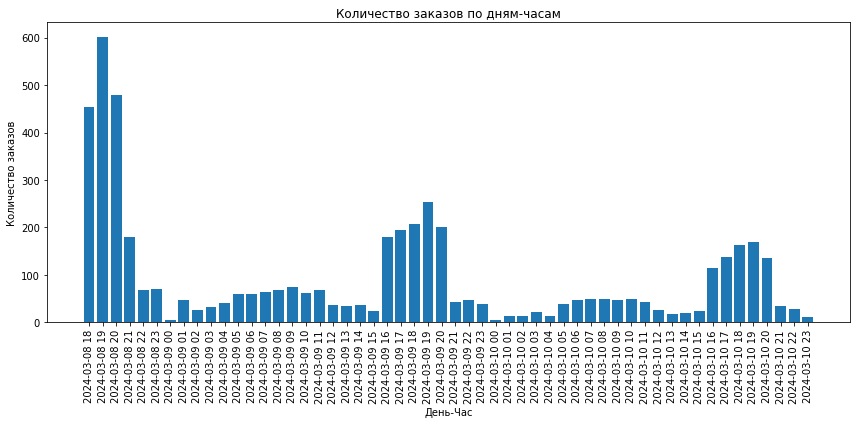

In [342]:
plt.figure(figsize=(12, 6))

plt.bar(
    df_mistakes_agg['day_hour'],
    df_mistakes_agg['count']
)

plt.xlabel('День-Час')
plt.ylabel('Количество заказов')
plt.title('Количество заказов по дням-часам')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Вывод: в датасете имеется 5017 заказов из 12281 номера заказов в которых нарушаю возрастающий порядок.   
Проблемы начались 2024-03-08 в 18 часов.   
Пик пришелся на 2024-03-08 19 часов, когда 602 заказа были созданы с нарушающим порядок номерами id.   

С чем связан этот сбой мне неизвестно. Одна из гипотез, что конкретный диапазон номеров мог быть заранее зарезервирован для конкретных целей и начат использован в заданное время. Во всяком случае вся эта информация пока не оказывает никакого влияния на данные для самого экперимента, и остается просто справочной.

Я закончил предварительный анализ данных и их чистку. Данные подготовленны для полноценного анализа


---

# Предложить способ автоматически определять отложенные заказы

Поскольку у пассажиров есть некая верхняя граница ожидания в минутах, дольше которой они не готовы ожидать машину для срочных заказов, то все, что выше этой границы можно будет считать отложенными заказами. Таким образом должно образоваться две моды времени ожидания для разных типов заказа. Одна будет стримиться к нулю для срочных заказов, и одна стремящаяся к бесконечности для отложенных заказов. Для определения этого времени я предлагаю взять разницу между временем создания заказа клиентом и временем когда водитель приезжает на этот заказ, это этап воронки Order2Arrive.

Нахожу разницу между созданием заказа и подачей машины на точку А, и округляю до минут

In [343]:
df_sorted['Order2Arrive_time'] = round((df_sorted.time_arrive - df_sorted.time_order).dt.total_seconds() / 60, 0)

Агрегирую данные по минутам потраченным на ожидания

In [344]:
df_wait = df_sorted.groupby('Order2Arrive_time', dropna=True).agg(count=('Order2Arrive_time', 'count'))
df_wait

,count
Order2Arrive_time,
2.0,84
3.0,205
4.0,365
5.0,478
6.0,590
...,...
4328.0,2
4329.0,2
4330.0,1


Построю график распределения количества минут ожидания

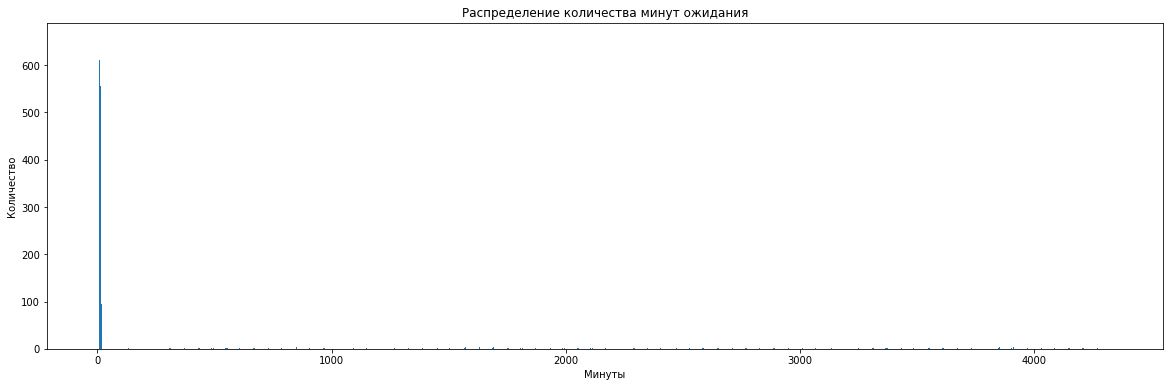

In [345]:
plt.figure(figsize=(20, 6))
plt.bar(df_wait.index, df_wait['count'])
plt.xlabel('Минуты')
plt.ylabel('Количество')
plt.title('Распределение количества минут ожидания')
plt.show()

Рассмотрю только область в пределах первых 120 минут

In [346]:
minutes_120 = df_wait[df_wait.index < 120]
minutes_120

,count
Order2Arrive_time,
2.0,84
3.0,205
4.0,365
5.0,478
6.0,590
7.0,605
8.0,629
9.0,610
10.0,623


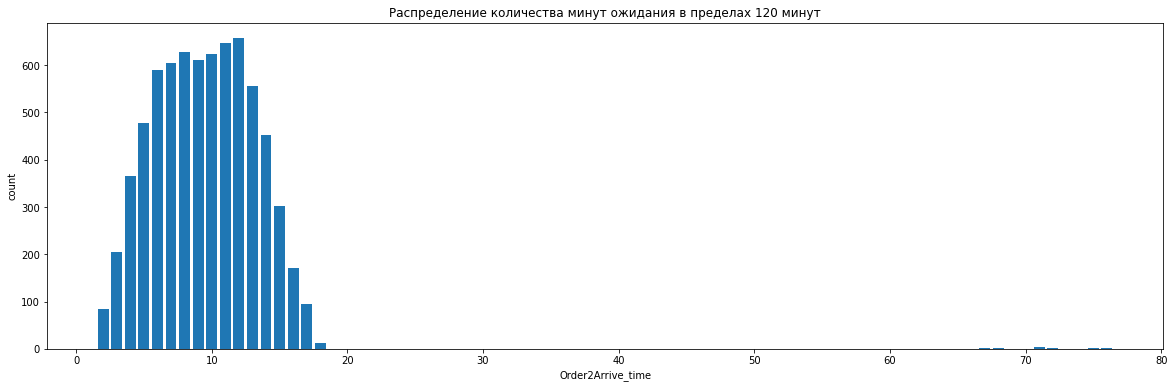

In [347]:
plt.figure(figsize=(20, 6))
plt.bar(minutes_120.index, minutes_120['count'])
plt.xlabel('Order2Arrive_time')
plt.ylabel('count')
plt.title('Распределение количества минут ожидания в пределах 120 минут')
plt.show()

Вывод: данные таблицы и графика показывают, что имеется очевидный разрыв во времени ожидания между срочными заказами и отложенными. По имеющимся данным верхняя граница ожидания для срочных составляет 18 минут, а нижняя для отложенных 61 минут.

Оставлю только данные с временем ожидания меньше 19 минут

In [348]:
minutes_19 = minutes_120[minutes_120.index < 19]
minutes_19

,count
Order2Arrive_time,
2.0,84
3.0,205
4.0,365
5.0,478
6.0,590
7.0,605
8.0,629
9.0,610
10.0,623


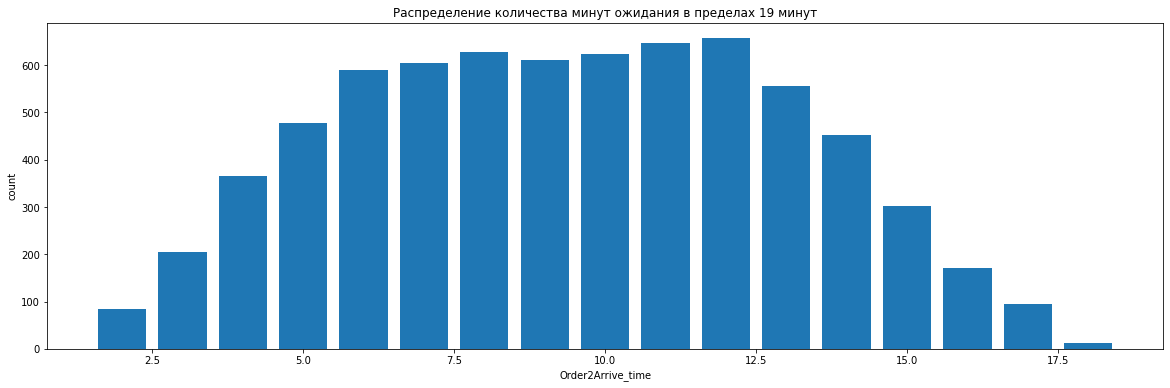

In [349]:
plt.figure(figsize=(20, 6))
plt.bar(minutes_19.index, minutes_19['count'])
plt.xlabel('Order2Arrive_time')
plt.ylabel('count')
plt.title('Распределение количества минут ожидания в пределах 19 минут')
plt.show()

По моему способу определения отложенных заказов я предлагаю считать срочными заказами все заказы время ожидания которых составляет меньше 19 минут, а все что больше считать отложенными. Но есть проблема в том, что данные на которых я считал это только выборка, а в генеральной совокупности данных будет больше, и следовательно рамки распределения срочных заказов могут быть шире. Поэтому я создам симуляцию генеральной совокупности взяв среднее взвешенное и взвешенное стандартное отклонения этой выборки срочных заказов.

In [350]:
# создам список содержащий значения минут ожидания
x = minutes_19.index.values
# вес каждой минуты
w = minutes_19['count'].values

# взвешенное среднее
mean_w = np.average(x, weights=w)

# взвешенная дисперсия и стандартное отклонения
variance_w = np.average((x - mean_w)**2, weights=w)
std_w = np.sqrt(variance_w)

print("Взвешенное среднее:", mean_w)
print("Взвешенное стандартное отклонение:", std_w)

# симуляция генеральной совокупности
sim_size = 10000 
simulated_data = np.random.normal(loc=mean_w, scale=std_w, size=sim_size)

Взвешенное среднее: 9.436237819517018
Взвешенное стандартное отклонение: 3.5839531060850347


Таблица с данными симуляции генеральной совокупности

In [351]:
simulated_df = pd.DataFrame({'simulated_minutes': simulated_data})
simulated_df

,simulated_minutes
0,19.075177
1,11.623903
2,2.955304
3,6.970606
4,4.915119
...,...
9995,10.529015
9996,10.718317
9997,4.814978
9998,12.217967


Построю график распределения симуляции генеральной совокупности

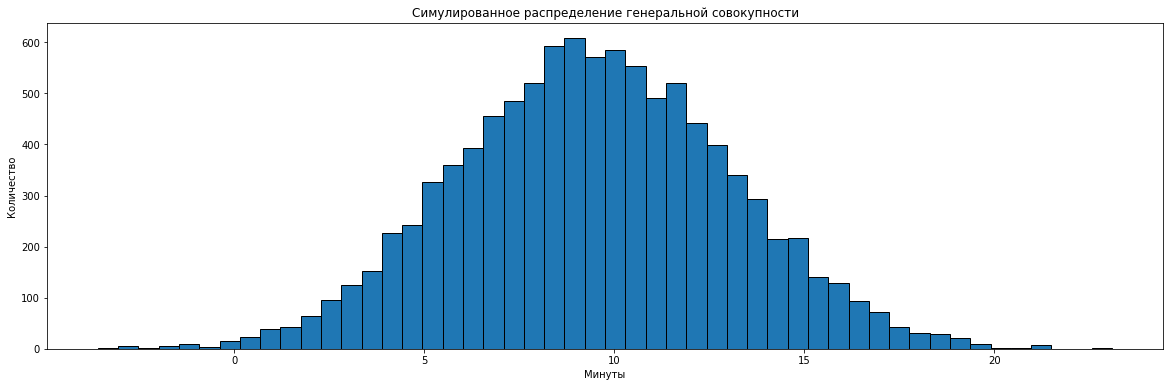

In [352]:
plt.figure(figsize=(20,6))
plt.hist(simulated_df['simulated_minutes'], bins=50, edgecolor='black')
plt.xlabel('Минуты')
plt.ylabel('Количество')
plt.title('Симулированное распределение генеральной совокупности')
plt.show()

Найду максимальное значение минут в симулированных данных

In [353]:
simulated_df.max()

simulated_minutes    23.113274
dtype: float64

Новое значение 23 минуты

**Общий вывод: отложенными заказами предлагаю считать все те заказы в которых время между созданием заказа (time_order) и временем подачи машины на первую точку (time_arrive), т.е. воронка Order2Arrive, составляет больше 23 минут**

---

## Убедиться, что сплит-система A/B теста работает верно и действительно разбивает выборку в отношении 50 на 50 случайным образом

In [354]:
df_sorted.shape[0]

12281

Всего в эксперименте участвовало 12281 заказов

Создам отдельные датасеты для каждой группы

In [355]:
df_control = df_sorted.query('test_group == 0')
df_test = df_sorted.query('test_group == 1')

In [356]:
df_control.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time,Order2Arrive_time
0,10001,0,2024-03-04 00:00:01,2024-03-04 00:00:42,2024-03-04 00:01:13,2024-03-04 00:09:07,2024-03-04 01:27:28,9.0
1,10002,0,2024-03-04 00:00:22,2024-03-04 00:01:00,2024-03-04 00:01:14,2024-03-04 00:08:45,2024-03-04 00:22:22,8.0
4,10005,0,2024-03-04 00:11:59,2024-03-04 00:12:50,2024-03-04 00:13:09,2024-03-04 00:21:43,2024-03-04 00:46:45,10.0
7,10008,0,2024-03-04 00:39:49,2024-03-04 00:40:24,2024-03-04 00:40:54,2024-03-04 00:42:57,2024-03-04 01:48:37,3.0
8,10009,0,2024-03-04 00:44:29,2024-03-04 00:45:33,2024-03-04 00:46:03,2024-03-04 00:47:02,2024-03-04 01:16:10,3.0


In [357]:
df_test.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time,Order2Arrive_time
2,10003,1,2024-03-04 00:07:08,2024-03-04 00:07:44,NaT,NaT,NaT,NaN
3,10004,1,2024-03-04 00:07:11,2024-03-04 00:08:21,2024-03-04 00:08:46,2024-03-04 00:21:13,2024-03-04 01:23:25,14.0
5,10006,1,2024-03-04 00:32:12,2024-03-04 00:32:49,2024-03-04 00:33:19,NaT,NaT,NaN
6,10007,1,2024-03-04 00:33:56,2024-03-04 00:35:12,2024-03-04 00:35:33,2024-03-04 00:39:06,2024-03-04 01:38:21,5.0
9,10010,1,2024-03-04 00:52:33,2024-03-04 00:53:42,2024-03-04 00:54:07,NaT,NaT,NaN


Найду временные рамки для каждой группы

In [358]:
print('Контрольная группа \nНачало ', df_control.time_order.min(),'\nОкончание', df_control.time_order.max(),'\nДлительность', df_control.time_order.max()-df_control.time_order.min())
print('Тестовая группа \nНачало ', df_test.time_order.min(),'\nОкончание', df_test.time_order.max(),'\nДлительность', df_test.time_order.max()-df_test.time_order.min())

Контрольная группа 
Начало  2024-03-04 00:00:01 
Окончание 2024-03-10 23:33:23 
Длительность 6 days 23:33:22
Тестовая группа 
Начало  2024-03-04 00:07:08 
Окончание 2024-03-10 23:45:48 
Длительность 6 days 23:38:40


Временные рамки выглядят приемлемо 

Посчитаю количество созданных и завершенных заказов в каждой группе

In [359]:
control_count = df_control.time_order.notna().sum()
test_count = df_test.time_order.notna().sum()
control_end_trip = df_control.trip_time.notna().sum()
test_end_trip = df_test.trip_time.notna().sum()

print('Размер контрольной группы:',control_count,'\nРазмер тестовой группы:',test_count, \
     '\nВыполненных заказов контрольной группы:',control_end_trip,'\nВыполненных заказов тестовой группы:',test_end_trip)

Размер контрольной группы: 5684 
Размер тестовой группы: 6597 
Выполненных заказов контрольной группы: 3562 
Выполненных заказов тестовой группы: 3822


Построю график количества заказов в каждой группе

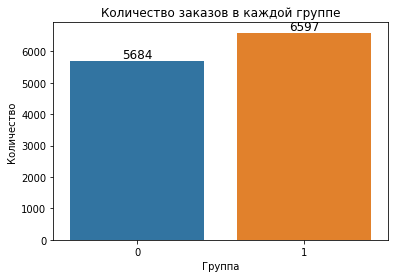

In [360]:
group_counts = df_sorted.test_group.value_counts().sort_index()

ax = sns.barplot(x=group_counts.index, y=group_counts.values)
ax.bar_label(ax.containers[0], label_type='edge', fontsize=12)
plt.xlabel('Группа')
plt.ylabel('Количество')
plt.title('Количество заказов в каждой группе')
plt.show()

Построю график количества завершенных заказов в каждой группе

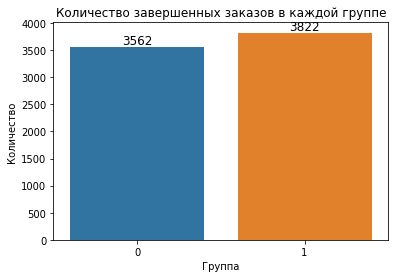

In [361]:
group_counts = df_sorted[df_sorted['trip_time'].notna()].test_group.value_counts().sort_index()

ax = sns.barplot(x=group_counts.index, y=group_counts.values)
ax.bar_label(ax.containers[0], label_type='edge', fontsize=12)
plt.xlabel('Группа')
plt.ylabel('Количество')
plt.title('Количество завершенных заказов в каждой группе')
plt.show()

Виден перевес общего количества и выполненых заказов в тестовой группе

Построю график распределения количества заказов по дням в разрезе по группам

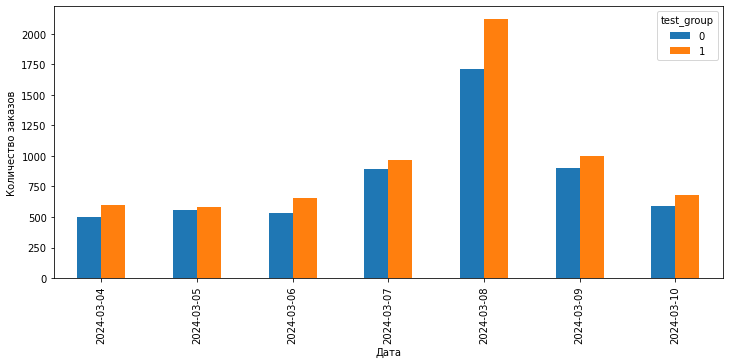

In [362]:
daily = df_sorted.groupby([df['time_order'].dt.date, 'test_group']).size().unstack(fill_value=0)
daily.plot(kind='bar', stacked=False, figsize=(12,5))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()


Виден перевес в количестве заказов в тестовой группе на протяжнии всех дней эксперемента

Рассчитываю математическое ожидание разделения участников при выполнения принципа 50 на 50

In [363]:
exp_value = df_sorted.shape[0]/2
exp_value

6140.5

Нахожу отклонение действительного количества участников групп от мат ожидания в процентах

In [364]:
actual_counts = df.test_group.value_counts().sort_index()
exp_value_ = pd.Series([len(df_sorted)*0.5]*2, index=[0,1])
percent_diff = ((actual_counts - exp_value) / exp_value) * 100

df_diff = pd.DataFrame({
    'actual': actual_counts,
    'expected': exp_value,
    'diff_percent': percent_diff.round(2)
})
df_diff

,actual,expected,diff_percent
0,5684,6140.5,-7.43
1,6597,6140.5,7.43


Вывод: отклонение количества участников от ожидаемого при разбивке 50 на 50 составляет 7.43%   
Теперь я хочу узнать насколько стат значимым и допустимым является такое отклонение

Нулевая гипотеза: количество участников в группах не отличается от ожидаемого при условии разделении групп 50% на 50%

Мы имеем дело с биномиальным распределением, использую функцию для расчета дисперсии и стандартного отклонения в наших данных

In [365]:
from scipy.stats import binom, norm

n = len(df_sorted)
p = 0.5

variance = binom.var(n, p)
std_dev = binom.std(n, p)

print('Дисперсия =', variance)
print('Стандартное отклонение =', std_dev)


Дисперсия = 3070.25
Стандартное отклонение = 55.40983667184014


Делаю Z-преобразование, и расчитываю отклонение действительных значений от ожидаемого в сигмах

In [366]:
group0 = df_diff.actual[0]
group1 = df_diff.actual[1]
z0 = (group0 - exp_value) / std_dev
z1 = (group1 - exp_value) / std_dev

print("Z-score (группа 0):", z0)
print("Z-score (группа 1):", z1)


Z-score (группа 0): -8.23860937731293
Z-score (группа 1): 8.23860937731293


Расчет p-value

In [367]:
p_value = 2 * (1 - norm.cdf(abs(z0)))
print("p-value:", p_value)

p-value: 2.220446049250313e-16


Расчитаю какие допустимые отклонения могут быть в группах при этом размере выборки

In [368]:
z = norm.ppf(1 - 0.05/2)
delta_count = z * std_dev
delta_percent = delta_count / exp_value * 100 

print('Допустимое отклонение количества участников =', delta_count)
print('Допустимое отклонение в процентах =', delta_percent)

Допустимое отклонение количества участников = 108.60128426605341
Допустимое отклонение в процентах = 1.7686065347455975


Построю график распределения

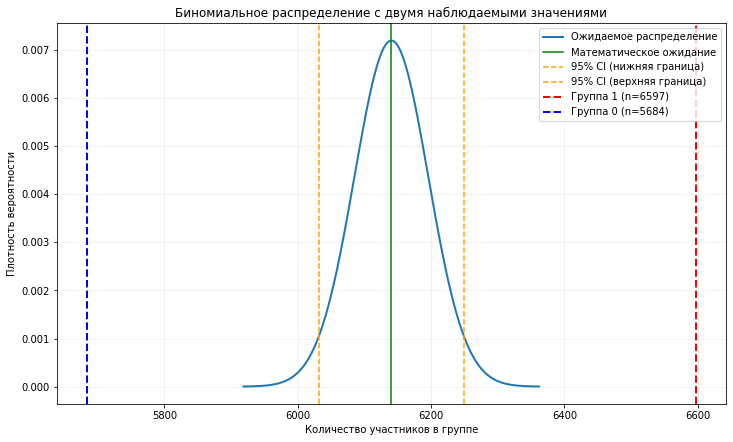

In [369]:
x = np.arange(exp_value - 4*std_dev, exp_value + 4*std_dev, 1)
pdf = norm.pdf(x, loc=exp_value, scale=std_dev)

ci_lower = exp_value - 1.96 * std_dev
ci_upper = exp_value + 1.96 * std_dev


plt.figure(figsize=(12,7))
plt.plot(x, pdf, label='Ожидаемое распределение', linewidth=2)

plt.axvline(exp_value, color='green', linestyle='-', label='Математическое ожидание')

plt.axvline(ci_lower, color='orange', linestyle='--', label='95% CI (нижняя граница)')
plt.axvline(ci_upper, color='orange', linestyle='--', label='95% CI (верхняя граница)')

plt.axvline(group1, color='red', linestyle='--', linewidth=2,
            label=f'Группа 1 (n={group1})')

plt.axvline(group0, color='blue', linestyle='--', linewidth=2,
            label=f'Группа 0 (n={group0})')

plt.xlabel('Количество участников в группе')
plt.ylabel('Плотность вероятности')
plt.title('Биномиальное распределение с двумя наблюдаемыми значениями')
plt.legend()
plt.grid(alpha=0.2)
plt.show()


На графике наглядно видно как далеко находятся значения количества участников групп от ожидаемого

Вывод: отклонение значений от ожидаемого составило +/-8.23 сигм, при допустимых +/-1.96 при альфа=0.95. P-value = 0.0000000000000002.  
Таким образом я отклоняю нулевую теорию и принимаю альтернативную.
Распределение в группах стат значимо отличается от ожидаемого при распределении 50% на 50%. Отлонение в группах составляет 7.43% при допустмых 1.76%. Сплит-система сработала неверно

Я хочу найти причину почему сплит-система сработала неверно

Хочу выяснить, был ли размер выборок каждой группы достаточен для проведения A/B теста.  
Поскольку размеры групп и конверсия известны, нужно рассчитать минимальный детектируемый эффект (MDE) который может дать размер этих групп, и определить вписываются ли реальные результаты в него

In [370]:
# расчет конверсии для каждой группы
p1 = control_end_trip / control_count  
p2 = test_end_trip / test_count      

print("Конверсия контрольной группы:", round(p1, 4))
print("Конверсия тестовой группы:", round(p2, 4))

# наблюдаемая разница между конверсиями
effect_size_obs = abs(p2 - p1)
print("Наблюдаемая разница конверсий:", round(effect_size_obs, 4))

# общая концерсия
p_pool = (control_end_trip + test_end_trip) / (control_count + test_count) 
print("Общая конверсия:", round(p_pool, 4))

# стандартная ошибка
se = np.sqrt(p_pool * (1 - p_pool) * (1/control_count + 1/test_count))

# расчет мощности теста при альфа = 0.05
alpha = 0.05
z_alpha = norm.ppf(1 - alpha/2)
power = 1 - norm.cdf(z_alpha - effect_size_obs / se)

# минимальный детертируемый эффект (MDE) при мощности 0.8
target_power = 0.8
z_beta = norm.ppf(target_power)
mde = (z_alpha + z_beta) * se

print("Мощность теста при наблюдаемой разницы:", round(power, 4))
print("Минимальная детектируемая разница (MDE):", round(mde, 4))


Конверсия контрольной группы: 0.6267
Конверсия тестовой группы: 0.5794
Наблюдаемая разница конверсий: 0.0473
Общая конверсия: 0.6013
Мощность теста при наблюдаемой разницы: 0.9996
Минимальная детектируемая разница (MDE): 0.0248


Вывод: размеры групп достаточны чтобы наблюдаемая разница конверсий была статистически значимой

Ранее на графике распределения количества заказов по дням я видел перекос в пользу тестовой группы. Хочу выяснить если какая-то зависимость групп от дня недели.  
Нулевая гипотеза: распределение участников по группам НЕ зависит от дня недели.

Для проверки этой гипотезы я буду использовать Критерий Хи-квадрат

In [371]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df_sorted['time_order'].dt.date, df_sorted['test_group'])

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("Хи-квадрат статистика:", chi2_stat)
print("Степени свободы:", dof)
print("p-value:", p_value)

Хи-квадрат статистика: 11.221326697195298
Степени свободы: 6
p-value: 0.08177223105300303


Вывод: p-value больше 0.05, я не могу отклонить нулевую гипотезу. Количество заказов в группах не зависит от дня недели.

Хочу выяснить, есть ли зависимость размера групп по срочным и отложенным заказам. Посчитаю их количество для каждой из групп. Поскольку по части заказов водители так и были назначенны на заказы или еще не приехали на первую точку, то такие заказы невозможно определить к какой категории они относятся и я исключу эти заказы из этого подсчета

In [372]:
# отбрасываю строки с NaN значениями в столбце Order2Arrive_time
df_filtered = df_sorted[df_sorted['Order2Arrive_time'].notna()]

# создаю новый столбец с категориями срочных и отложенных заказов
df_filtered['orders_category'] = df_filtered['Order2Arrive_time'].apply(lambda x: 'post_orders' if x > 23 else 'imm_orders')

# группирую по test_group и orders_category
df_category = df_filtered.groupby(['test_group', 'orders_category']).size().unstack(fill_value=0)
df_category

c:\users\igor\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


orders_category,imm_orders,post_orders
test_group,,
0,3689,0
1,3392,643


Проведу Критерий Хи-квадрат зависимости размера групп от категорий заказов.

Нулевая гипотиза: размеры групп НЕ зависит от категории заказов

In [373]:
contingency_table2 = pd.crosstab(df_filtered['orders_category'], df_filtered['test_group'])

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table2)

print("Хи-квадрат статистика:", chi2_stat)
print("Степени свободы:", dof)
print("p-value:", p_value)

Хи-квадрат статистика: 639.1582808615401
Степени свободы: 1
p-value: 5.0933296996901525e-141


Вывод: p-value < 0.05, отклоняю нулевую теорию и принимаю альтернативную. Размеры групп зависят от категорий заказов. Как видно по данным все отложенные заказы попали в тестовую группу и отсутствуют в контрольной группе. 

**Общий вывод: сплит-система сработала неверно и не разбивает группы 50 на 50 случайным образом. Причиной этого является то, что все отложенные заказы попали только в тестовую группу**

---

## Рассчитать результаты A/B теста и сделать вывод выгодна ли новая механика

Поскольку на предыдущем шаге я выяснил, что сплит-система вынесла все отложенные заказы в тестовую группу, то их банально не с чем сравнивать в контрольной группе. Поэтому я исключу все отложенные заказы из результатов A/B теста и рассмотрю их отдельно позже. 

In [374]:
df_sorted['Order2Assign_time'] = round((df_sorted.time_assign - df_sorted.time_order).dt.total_seconds() / 60, 0)

In [375]:
df_ab = df_sorted.query("~(Order2Assign_time > 18)")

In [376]:
df_ab.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time,Order2Arrive_time,Order2Assign_time
0,10001,0,2024-03-04 00:00:01,2024-03-04 00:00:42,2024-03-04 00:01:13,2024-03-04 00:09:07,2024-03-04 01:27:28,9.0,1.0
1,10002,0,2024-03-04 00:00:22,2024-03-04 00:01:00,2024-03-04 00:01:14,2024-03-04 00:08:45,2024-03-04 00:22:22,8.0,1.0
2,10003,1,2024-03-04 00:07:08,2024-03-04 00:07:44,NaT,NaT,NaT,NaN,NaN
3,10004,1,2024-03-04 00:07:11,2024-03-04 00:08:21,2024-03-04 00:08:46,2024-03-04 00:21:13,2024-03-04 01:23:25,14.0,2.0
4,10005,0,2024-03-04 00:11:59,2024-03-04 00:12:50,2024-03-04 00:13:09,2024-03-04 00:21:43,2024-03-04 00:46:45,10.0,1.0


Вынесу группы в отдельные датафреймы

In [377]:
df_ab_control = df_ab[df_ab.test_group == 0]
df_ab_control.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time,Order2Arrive_time,Order2Assign_time
0,10001,0,2024-03-04 00:00:01,2024-03-04 00:00:42,2024-03-04 00:01:13,2024-03-04 00:09:07,2024-03-04 01:27:28,9.0,1.0
1,10002,0,2024-03-04 00:00:22,2024-03-04 00:01:00,2024-03-04 00:01:14,2024-03-04 00:08:45,2024-03-04 00:22:22,8.0,1.0
4,10005,0,2024-03-04 00:11:59,2024-03-04 00:12:50,2024-03-04 00:13:09,2024-03-04 00:21:43,2024-03-04 00:46:45,10.0,1.0
7,10008,0,2024-03-04 00:39:49,2024-03-04 00:40:24,2024-03-04 00:40:54,2024-03-04 00:42:57,2024-03-04 01:48:37,3.0,1.0
8,10009,0,2024-03-04 00:44:29,2024-03-04 00:45:33,2024-03-04 00:46:03,2024-03-04 00:47:02,2024-03-04 01:16:10,3.0,2.0


In [378]:
df_ab_test = df_ab[df_ab.test_group == 1]
df_ab_test.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time,Order2Arrive_time,Order2Assign_time
2,10003,1,2024-03-04 00:07:08,2024-03-04 00:07:44,NaT,NaT,NaT,NaN,NaN
3,10004,1,2024-03-04 00:07:11,2024-03-04 00:08:21,2024-03-04 00:08:46,2024-03-04 00:21:13,2024-03-04 01:23:25,14.0,2.0
5,10006,1,2024-03-04 00:32:12,2024-03-04 00:32:49,2024-03-04 00:33:19,NaT,NaT,NaN,1.0
6,10007,1,2024-03-04 00:33:56,2024-03-04 00:35:12,2024-03-04 00:35:33,2024-03-04 00:39:06,2024-03-04 01:38:21,5.0,2.0
9,10010,1,2024-03-04 00:52:33,2024-03-04 00:53:42,2024-03-04 00:54:07,NaT,NaT,NaN,2.0


In [379]:
df_ab_control.isna().sum()

id_order                0
test_group              0
time_order              0
time_offer            838
time_assign          1399
time_arrive          1995
trip_time            2122
Order2Arrive_time    1995
Order2Assign_time    1399
dtype: int64

In [380]:
df_ab_test.isna().sum()

id_order                0
test_group              0
time_order              0
time_offer            662
time_assign          1258
time_arrive          2285
trip_time            2410
Order2Arrive_time    2285
Order2Assign_time    1258
dtype: int64

Количество заказов в каждой группе после исключения отложенных заказов из тестовой группы

In [381]:
df_ab.test_group.value_counts()

0    5684
1    5677
Name: test_group, dtype: int64

In [382]:
control_count = df_ab_control.time_order.notna().sum()
test_count = df_ab_test.time_order.notna().sum()

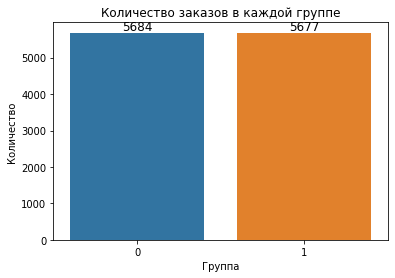

In [383]:
group_counts = df_ab.test_group.value_counts().sort_index()

ax = sns.barplot(x=group_counts.index, y=group_counts.values)
ax.bar_label(ax.containers[0], label_type='edge', fontsize=12)
plt.xlabel('Группа')
plt.ylabel('Количество')
plt.title('Количество заказов в каждой группе')
plt.show()

Рассчитаю необходимые метрики и временные показатели для контрольной группы

In [384]:
sum_order = df_ab_control.time_order.notna().sum()
sum_offer = df_ab_control.time_offer.notna().sum()
sum_assign = df_ab_control.time_assign.notna().sum()
sum_arrive = df_ab_control.time_arrive.notna().sum()
sum_trip = df_ab_control.trip_time.notna().sum()

Order2Offer = sum_offer / sum_order
Order2Assign = sum_assign / sum_order
Order2Arrive = sum_arrive / sum_order
Offer2Assign = sum_assign / sum_offer
Assign2Arrive = sum_arrive / sum_assign
Arrive2Trip = sum_trip / sum_arrive
Order2Trip = sum_trip / sum_order

Order2Offer_time = ((df_ab_control.time_offer - df_ab_control.time_order).dt.total_seconds() / 60).mean()
Order2Assign_time = ((df_ab_control.time_assign - df_ab_control.time_order).dt.total_seconds() / 60).mean()
Order2Arrive_time = ((df_ab_control.time_arrive - df_ab_control.time_order).dt.total_seconds() / 60).mean()
Order2Trip_time = ((df_ab_control.trip_time - df_ab_control.time_order).dt.total_seconds() / 60).mean()
Offer2Assign_time = ((df_ab_control.time_assign - df_ab_control.time_offer).dt.total_seconds() / 60).mean()
Assign2Arrive_time = ((df_ab_control.time_arrive - df_ab_control.time_assign).dt.total_seconds() / 60).mean()
Arrive2Trip_time = ((df_ab_control.trip_time - df_ab_control.time_arrive).dt.total_seconds() / 60).mean()

percent_dict = {
    "Order2Offer": Order2Offer,
    "Order2Assign": Order2Assign,
    "Order2Arrive": Order2Arrive,
    "Offer2Assign": Offer2Assign,
    "Assign2Arrive": Assign2Arrive,
    "Arrive2Trip": Arrive2Trip,
    "Order2Trip": Order2Trip
}

time_dict = {
    "Order2Offer": Order2Offer_time,
    "Order2Assign": Order2Assign_time,
    "Order2Arrive": Order2Arrive_time,
    "Offer2Assign": Offer2Assign_time,
    "Assign2Arrive": Assign2Arrive_time,
    "Arrive2Trip": Arrive2Trip_time,
    "Order2Trip": Order2Trip_time
}

step_descriptions = [
    'От создания заказа до предложения водителю',
    'От создания заказа до принятия заказа водителем',
    'От создания заказа до приезда водителя на точку А',
    'От предложения заказа водителю до его принятия',
    'От принятия заказа водителем до приезда на точку А',
    'Поездка от точки А до точки В',
    'От создания заказа до выполнения заказа на точке В']


control_metrics = pd.DataFrame({
    "%": percent_dict,
    "time_mins": time_dict})

control_metrics["description"] = step_descriptions
control_metrics['%'] = round(control_metrics['%']*100, 2)
control_metrics['time_mins'] = round(control_metrics['time_mins'], 2)

Таблица с метриками контрольной группы

In [385]:
control_metrics

,%,time_mins,description
Order2Offer,85.26,1.14,От создания заказа до предложения водителю
Order2Assign,75.39,1.60,От создания заказа до принятия заказа водителем
Order2Arrive,64.90,8.35,От создания заказа до приезда водителя на точку А
Offer2Assign,88.42,0.48,От предложения заказа водителю до его принятия
Assign2Arrive,86.09,6.75,От принятия заказа водителем до приезда на точ...
Arrive2Trip,96.56,50.12,Поездка от точки А до точки В
Order2Trip,62.67,58.46,От создания заказа до выполнения заказа на точ...


Строю график воронки контрольной группы

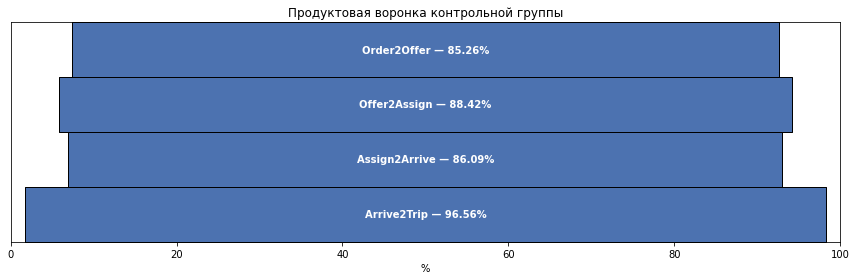

In [386]:
steps = ["Order2Offer", "Offer2Assign", "Assign2Arrive", "Arrive2Trip"]

df_steps = control_metrics.loc[steps]

fig, ax = plt.subplots(figsize=(12, 4))
max_width = 100
n = len(df_steps)
color = "#4C72B0"

for i, step in enumerate(df_steps.index):
    value = control_metrics.loc[step, "%"]  # процент для ширины сегмента
    y_top = n - i - 1
    y_bottom = y_top + 1

    ax.fill_betweenx(
        [y_top, y_bottom],
        (max_width - value) / 2,
        (max_width + value) / 2,
        color=color,
        edgecolor='black',
        linewidth=1
    )

    ax.text(
        max_width / 2,
        y_top + 0.5,
        f"{steps[i]} — {value}%",
        ha="center",
        va="center",
        color="white",
        fontsize=10,
        fontweight="bold")

ax.set_xlim(0, max_width)
ax.set_ylim(0, n)
ax.set_yticks([])
ax.set_xlabel('%')
ax.set_title("Продуктовая воронка контрольной группы")
plt.tight_layout()
plt.show()


Строю график главной конверсии контрольной группы

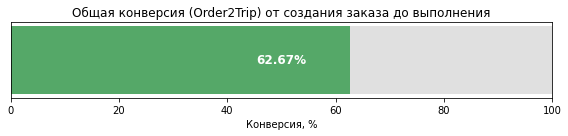

In [387]:
value = control_metrics.loc["Order2Trip", "%"]

fig, ax = plt.subplots(figsize=(8, 2))

ax.barh(0, 100, color="#e0e0e0", height=0.5)

ax.barh(0, value, color="#55A868", height=0.5)

ax.text(50, 0, f"{value}%", ha="center", va="center", color="white", fontsize=12, fontweight="bold")

ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_xlabel("Конверсия, %")
ax.set_title("Общая конверсия (Order2Trip) от создания заказа до выполнения")

plt.tight_layout()
plt.show()


Строю график времени выполнения каждого этапа заказа контрольной группы

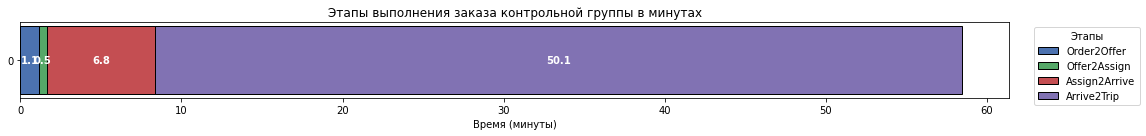

In [388]:
# Шаги воронки
time_steps = ["Order2Offer", "Offer2Assign", "Assign2Arrive", "Arrive2Trip"]
df_funnel = control_metrics.loc[time_steps]

fig, ax = plt.subplots(figsize=(16, 2))

y = [0]  
left = 0  

colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"] 
for i, step in enumerate(df_funnel.index):
    width = df_funnel.loc[step, "time_mins"]
    bar = ax.barh(y, width, left=left, color=colors[i], edgecolor="black")
    
    ax.text(left + width/2, y[0], f"{width:.1f}",
            ha="center", va="center", color="white", fontsize=10, fontweight="bold")
    
    left += width  

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], edgecolor="black", label=step) 
                   for i, step in enumerate(df_funnel.index)]
ax.legend(handles=legend_elements, title="Этапы", bbox_to_anchor=(1.02, 1), loc="upper left")

ax.set_yticks([0])
ax.set_xlabel("Время (минуты)")
ax.set_title("Этапы выполнения заказа контрольной группы в минутах")
ax.invert_yaxis() 
plt.tight_layout()
plt.show()


---

Рассчитаю необходимые метрики и временные показатели для тестовой группы

In [389]:
sum_order = df_ab_test.time_order.notna().sum()
sum_offer = df_ab_test.time_offer.notna().sum()
sum_assign = df_ab_test.time_assign.notna().sum()
sum_arrive = df_ab_test.time_arrive.notna().sum()
sum_trip = df_ab_test.trip_time.notna().sum()

Order2Offer = sum_offer / sum_order
Order2Assign = sum_assign / sum_order
Order2Arrive = sum_arrive / sum_order
Offer2Assign = sum_assign / sum_offer
Assign2Arrive = sum_arrive / sum_assign
Arrive2Trip = sum_trip / sum_arrive
Order2Trip = sum_trip / sum_order

Order2Offer_time = ((df_ab_test.time_offer - df_ab_test.time_order).dt.total_seconds() / 60).mean()
Order2Assign_time = ((df_ab_test.time_assign - df_ab_test.time_order).dt.total_seconds() / 60).mean()
Order2Arrive_time = ((df_ab_test.time_arrive - df_ab_test.time_order).dt.total_seconds() / 60).mean()
Order2Trip_time = ((df_ab_test.trip_time - df_ab_test.time_order).dt.total_seconds() / 60).mean()
Offer2Assign_time = ((df_ab_test.time_assign - df_ab_test.time_offer).dt.total_seconds() / 60).mean()
Assign2Arrive_time = ((df_ab_test.time_arrive - df_ab_test.time_assign).dt.total_seconds() / 60).mean()
Arrive2Trip_time = ((df_ab_test.trip_time - df_ab_test.time_arrive).dt.total_seconds() / 60).mean()

percent_dict = {
    "Order2Offer": Order2Offer,
    "Order2Assign": Order2Assign,
    "Order2Arrive": Order2Arrive,
    "Offer2Assign": Offer2Assign,
    "Assign2Arrive": Assign2Arrive,
    "Arrive2Trip": Arrive2Trip,
    "Order2Trip": Order2Trip
}

time_dict = {
    "Order2Offer": Order2Offer_time,
    "Order2Assign": Order2Assign_time,
    "Order2Arrive": Order2Arrive_time,
    "Offer2Assign": Offer2Assign_time,
    "Assign2Arrive": Assign2Arrive_time,
    "Arrive2Trip": Arrive2Trip_time,
    "Order2Trip": Order2Trip_time
}

step_descriptions = [
    'От создания заказа до предложения водителю',
    'От создания заказа до принятия заказа водителем',
    'От создания заказа до приезда водителя на точку А',
    'От предложения заказа водителю до его принятия',
    'От принятия заказа водителем до приезда на точку А',
    'Поездка от точки А до точки В',
    'От создания заказа до выполнения заказа на точке В']


test_metrics = pd.DataFrame({
    "%": percent_dict,
    "time_mins": time_dict})

test_metrics["description"] = step_descriptions
test_metrics['%'] = round(test_metrics['%']*100, 2)
test_metrics['time_mins'] = round(test_metrics['time_mins'], 2)

Таблица с метриками тестовой группы

In [390]:
test_metrics

,%,time_mins,description
Order2Offer,88.34,1.15,От создания заказа до предложения водителю
Order2Assign,77.84,1.62,От создания заказа до принятия заказа водителем
Order2Arrive,59.75,10.62,От создания заказа до приезда водителя на точку А
Offer2Assign,88.12,0.48,От предложения заказа водителю до его принятия
Assign2Arrive,76.76,9.01,От принятия заказа водителем до приезда на точ...
Arrive2Trip,96.31,49.22,Поездка от точки А до точки В
Order2Trip,57.55,59.85,От создания заказа до выполнения заказа на точ...


Строю график воронки тестовой группы

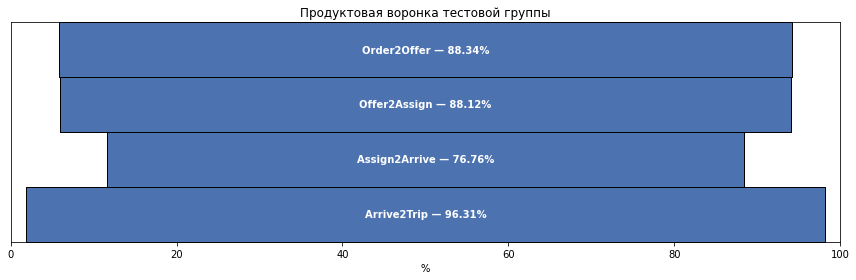

In [391]:
steps = ["Order2Offer", "Offer2Assign", "Assign2Arrive", "Arrive2Trip"]

df_steps = test_metrics.loc[steps]

fig, ax = plt.subplots(figsize=(12, 4))
max_width = 100
n = len(df_steps)
color = "#4C72B0"

for i, step in enumerate(df_steps.index):
    value = test_metrics.loc[step, "%"]  # процент для ширины сегмента
    y_top = n - i - 1
    y_bottom = y_top + 1

    ax.fill_betweenx(
        [y_top, y_bottom],
        (max_width - value) / 2,
        (max_width + value) / 2,
        color=color,
        edgecolor='black',
        linewidth=1
    )

    ax.text(
        max_width / 2,
        y_top + 0.5,
        f"{steps[i]} — {value}%",
        ha="center",
        va="center",
        color="white",
        fontsize=10,
        fontweight="bold")

ax.set_xlim(0, max_width)
ax.set_ylim(0, n)
ax.set_yticks([])
ax.set_xlabel('%')
ax.set_title("Продуктовая воронка тестовой группы")
plt.tight_layout()
plt.show()

Строю график главной конверсии тестовой группы

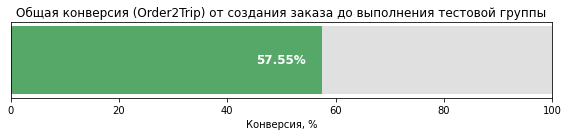

In [392]:
value = test_metrics.loc["Order2Trip", "%"]

fig, ax = plt.subplots(figsize=(8, 2))

ax.barh(0, 100, color="#e0e0e0", height=0.5)

ax.barh(0, value, color="#55A868", height=0.5)

ax.text(50, 0, f"{value}%", ha="center", va="center", color="white", fontsize=12, fontweight="bold")

ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_xlabel("Конверсия, %")
ax.set_title("Общая конверсия (Order2Trip) от создания заказа до выполнения тестовой группы")

plt.tight_layout()
plt.show()


Строю график времени выполнения каждого этапа заказа тестовой группы

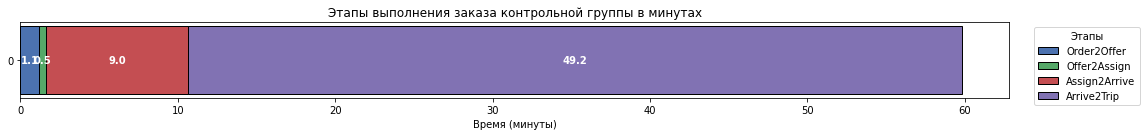

In [393]:
# Шаги воронки
time_steps = ["Order2Offer", "Offer2Assign", "Assign2Arrive", "Arrive2Trip"]
df_funnel = test_metrics.loc[time_steps]

fig, ax = plt.subplots(figsize=(16, 2))

y = [0]  
left = 0  

colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"] 
for i, step in enumerate(df_funnel.index):
    width = df_funnel.loc[step, "time_mins"]
    bar = ax.barh(y, width, left=left, color=colors[i], edgecolor="black")
    
    ax.text(left + width/2, y[0], f"{width:.1f}",
            ha="center", va="center", color="white", fontsize=10, fontweight="bold")
    
    left += width  

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], edgecolor="black", label=step) 
                   for i, step in enumerate(df_funnel.index)]
ax.legend(handles=legend_elements, title="Этапы", bbox_to_anchor=(1.02, 1), loc="upper left")

ax.set_yticks([0])
ax.set_xlabel("Время (минуты)")
ax.set_title("Этапы выполнения заказа контрольной группы в минутах")
ax.invert_yaxis() 
plt.tight_layout()
plt.show()

Приступаю к расчету статистики главной конверсии. Для контрольной группы она 62.7, для тестовой 57.6
Нулевая гипотеза: конверсии в группах не отличаются

Выведу надостающие показатели. Мне известны проценты конверсии для каждой группы, но неизвестны абсолютные величины

In [394]:
control_end_trip = df_ab_control.trip_time.notna().sum()
control_end_trip

3562

In [395]:
test_end_trip = df_ab_test.trip_time.notna().sum()
test_end_trip

3267

Приступаю к расчету статистики, проведу z-test. Нулевая теория: конверсии в группах не различаются

In [396]:
from math import sqrt

# конверсии групп
p_control = control_end_trip / control_count
p_test = test_end_trip / test_count

# общая конверсия
p_pool = (control_end_trip + test_end_trip) / (control_count + test_count)

# стандартная ошибка
se = sqrt(p_pool * (1 - p_pool) * (1/control_count + 1/test_count))

# z-статистика
z = (p_test - p_control) / se
p_value = 2 * (1 - norm.cdf(abs(z)))

print('Z-score = ',z)
print('p-value = ',p_value)

Z-score =  -5.571444995138672
p-value =  2.526351283727024e-08


Вывод: p-value меньше 0.05, поэтому я отклоняю нулевую гипотезу о равенстве конверсий. Конверсии статически значимо отличаются, конверсия в контрольной группе (62.7%) больше чем в тестовой (57.6%). 

Я заметил, что в воронке тестовой группы сильно просел шаг конверсии Assign2Arrive = 76.76 % От принятия заказа водителем до прибытия на точку А.  
Почти 24% клиентов в тестовой группе не дожидаются своего водителя на точке А, против 14% в контрольной группе. 
Поскольку механизмы назначения водителей на заказы неизвестны пассажиру, я пропущу эти этапы, и сравню время от оформелния заказа до подачи машины в двух группах, метрика Order2Arrive. Её время составляет 10.6 минут для тестовой группы, и 8.4 минуты для контольной. Я хочу выяснить является ли разница этих значений статистически значимой в нашем эксперименте.

Избавлюсь от строк с пустыми значениями которые не должны участвовать в статистике

In [397]:
df_ab_control_ = df_ab_control.dropna(subset=['Order2Arrive_time'])
df_ab_test_ = df_ab_test.dropna(subset=['Order2Arrive_time'])

In [398]:
df_ab_control_.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time,Order2Arrive_time,Order2Assign_time
0,10001,0,2024-03-04 00:00:01,2024-03-04 00:00:42,2024-03-04 00:01:13,2024-03-04 00:09:07,2024-03-04 01:27:28,9.0,1.0
1,10002,0,2024-03-04 00:00:22,2024-03-04 00:01:00,2024-03-04 00:01:14,2024-03-04 00:08:45,2024-03-04 00:22:22,8.0,1.0
4,10005,0,2024-03-04 00:11:59,2024-03-04 00:12:50,2024-03-04 00:13:09,2024-03-04 00:21:43,2024-03-04 00:46:45,10.0,1.0
7,10008,0,2024-03-04 00:39:49,2024-03-04 00:40:24,2024-03-04 00:40:54,2024-03-04 00:42:57,2024-03-04 01:48:37,3.0,1.0
8,10009,0,2024-03-04 00:44:29,2024-03-04 00:45:33,2024-03-04 00:46:03,2024-03-04 00:47:02,2024-03-04 01:16:10,3.0,2.0


In [399]:
df_ab_test_.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time,Order2Arrive_time,Order2Assign_time
3,10004,1,2024-03-04 00:07:11,2024-03-04 00:08:21,2024-03-04 00:08:46,2024-03-04 00:21:13,2024-03-04 01:23:25,14.0,2.0
6,10007,1,2024-03-04 00:33:56,2024-03-04 00:35:12,2024-03-04 00:35:33,2024-03-04 00:39:06,2024-03-04 01:38:21,5.0,2.0
16,10017,1,2024-03-04 01:23:26,2024-03-04 01:24:14,2024-03-04 01:24:46,2024-03-04 01:32:07,2024-03-04 01:55:23,9.0,1.0
28,10029,1,2024-03-04 02:04:50,2024-03-04 02:05:31,2024-03-04 02:06:06,2024-03-04 02:13:16,2024-03-04 03:40:03,8.0,1.0
32,10033,1,2024-03-04 02:11:09,2024-03-04 02:12:03,2024-03-04 02:12:41,2024-03-04 02:21:44,2024-03-04 02:38:46,11.0,2.0


Теперь я имею стобцы для расчета статитистика. Хочу выяснить является ли распределение нормальным.   
Построю графики распределения Order2Arrive_time

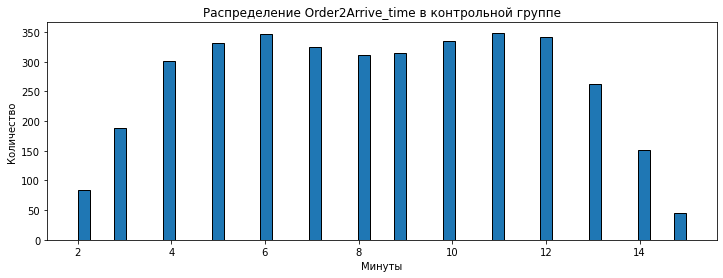

In [400]:
plt.figure(figsize=(12,4))
plt.hist(df_ab_control_['Order2Arrive_time'], bins=50, edgecolor='black')
plt.xlabel('Минуты')
plt.ylabel('Количество')
plt.title('Распределение Order2Arrive_time в контрольной группе')
plt.show()

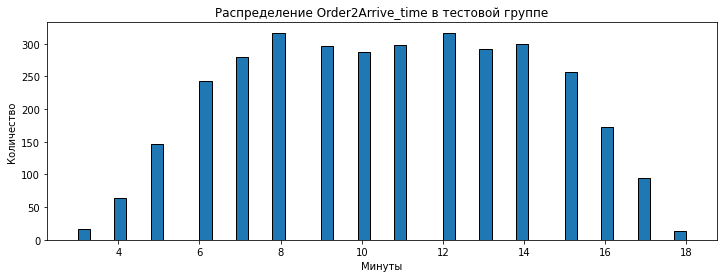

In [401]:
plt.figure(figsize=(12,4))
plt.hist(df_ab_test_['Order2Arrive_time'], bins=50, edgecolor='black')
plt.xlabel('Минуты')
plt.ylabel('Количество')
plt.title('Распределение Order2Arrive_time в тестовой группе')
plt.show()

Проведу тест Шапиро-Уилка.  Нулевая гипотеза: распределение в группах нормальные

In [402]:
from scipy.stats import shapiro

stat_c, p_c = shapiro(df_ab_control_.Order2Arrive_time)

print('Контрольная группа: s=',stat_c,'p=', p_c)

stat_t, p_t = shapiro(df_ab_test_.Order2Arrive_time)

print('Тестовая группа: s=',stat_t,'p=', p_t)


Контрольная группа: s= 0.9634386897087097 p= 1.3754567356372766e-29
Тестовая группа: s= 0.97113436460495 p= 1.300677681573414e-25


Вывод: в обеих группах p-value < 0.05, распределения в обеих группах не являются нормальными. Хоть на графиках распредления и выглядят почти нормальными, проблема теста Шапиро-Уилка в том, что он расчитан на малые значения размера выборки. А при размере выборки > 50 (в нашем случае > 3000) результат теста будет стримиться к ненормальности.

Дополнительно построю графики QQ-плот

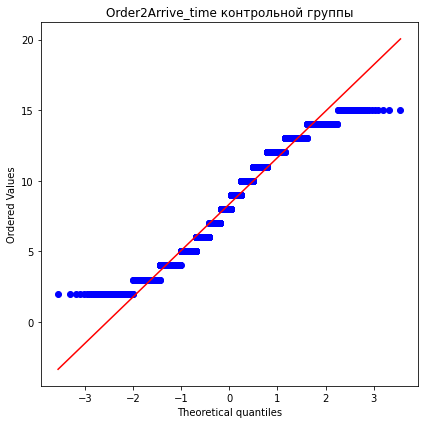

In [403]:
data = df_ab_control_["Order2Arrive_time"].dropna()

plt.figure(figsize=(6, 6))
stats.probplot(data, dist="norm", plot=plt)
plt.title("Order2Arrive_time контрольной группы")
plt.tight_layout()
plt.show()

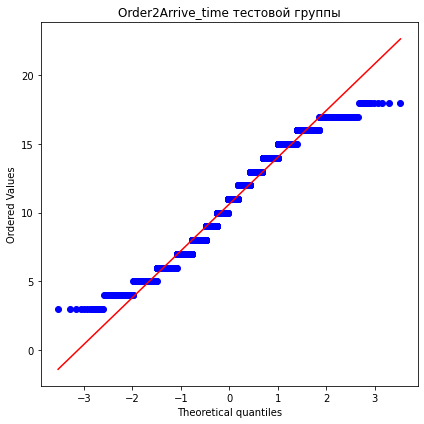

In [404]:
data = df_ab_test_["Order2Arrive_time"].dropna()

plt.figure(figsize=(6, 6))
stats.probplot(data, dist="norm", plot=plt)
plt.title("Order2Arrive_time тестовой группы")
plt.tight_layout()
plt.show()

Как видно из графиков распределение почти нормальные, отклонются тольхо хвосты

Теперь проведу тест на равенство дисперсий, буду использовать тест Левена. Нулевая гипотеза: дисперсии в группах равные

In [405]:
from scipy.stats import levene

stat_var, p_var = levene(df_ab_control_.Order2Arrive_time, df_ab_test_.Order2Arrive_time)

print('Сравнения групп: s=',stat_var,'p-value=', p_var)

Сравнения групп: s= 2.085931488361217 p-value= 0.148705773572691


Вывод: p-value > 0.05, принимаю нулевую гипотезу, дисперсии в группах равные

Теперь я сравню величны в двух группах с помощью критерия Манна-Уитни. Нулевая гипотеза: распределения двух выборок одинаковы

In [406]:
from scipy.stats import mannwhitneyu

control = df_ab_control_["Order2Arrive_time"].dropna()
test = df_ab_test_["Order2Arrive_time"].dropna()

u_stat, p_value = mannwhitneyu(
    control,
    test,
    alternative="two-sided"
)

print('Статистика:', u_stat, 'p-value:', p_value)

Статистика: 4079551.0 p-value: 1.928011692966388e-142


Теперь проведу t-test. Нулевая гипотеза: среднии в двух группах не различаются

In [407]:
from scipy.stats import ttest_ind

control = df_ab_control_["Order2Arrive_time"].dropna()
test = df_ab_test_["Order2Arrive_time"].dropna()

t_stat, p_value = ttest_ind(
    test,
    control,
    equal_var=True )

print('Статистика:', t_stat, 'p-value:', p_value)

Статистика: 28.20276195663112 p-value: 6.150015410896007e-166


Вывод: оба теста показали разницу между группами. Метрика Order2Arrive действительно упала в тестовой группе, водители стали приезжать на первую точку реже и дольше

Одной из целей эксперемента была задача повысить шанс найти водителя для заказа за счет расширения радиуса поиска. Для этого нужно проверить метрику Order2Offer. В контрольной группе значение 85.26%, в тестовой 88.34%. 

In [408]:
control_offer = df_ab_control.time_offer.notna().sum()
test_offer = df_ab_test.time_offer.notna().sum()

Приступаю к расчету статистики, проведу z-test. Нулевая гипотеза: конверсии в группах не различаются

In [409]:
# конверсии групп
p_control = control_offer / control_count
p_test = test_offer / test_count

# общая конверсия
p_pool = (control_offer + test_offer) / (control_count + test_count)

# стандартная ошибка
se = sqrt(p_pool * (1 - p_pool) * (1/control_count + 1/test_count))

# z-статистика
z = (p_test - p_control) / se
p_value = 2 * (1 - norm.cdf(abs(z)))

print('Z-score = ',z)
print('p-value = ',p_value)

Z-score =  4.852084294323731
p-value =  1.2217067260067438e-06


Вывод: p-value < 0.05, выбираю альтернативную гипотезу, конверсии не равны. Расширение радиуса поиска водителей повысило предложение зазаков водителям на 3%.

Создам сводную таблицу с метриками обеих групп

In [410]:
test_metrics['group'] = 1
control_metrics['group'] = 0

In [411]:
metrics = pd.concat([test_metrics, control_metrics], ignore_index=False, axis=0).drop(columns=['description'])

In [412]:
metrics

,%,time_mins,group
Order2Offer,88.34,1.15,1
Order2Assign,77.84,1.62,1
Order2Arrive,59.75,10.62,1
Offer2Assign,88.12,0.48,1
Assign2Arrive,76.76,9.01,1
Arrive2Trip,96.31,49.22,1
Order2Trip,57.55,59.85,1
Order2Offer,85.26,1.14,0
Order2Assign,75.39,1.60,0
Order2Arrive,64.90,8.35,0


Преобразую в таблицу с мультииндексами

In [413]:
# добавлю столбец с метрикой из индекса
metrics = metrics.reset_index().rename(columns={'index':'metric'})

# нужный порядок метрик в столбцах
metric_order = ['Order2Offer','Offer2Assign','Assign2Arrive','Arrive2Trip',
                'Order2Arrive','Order2Assign','Order2Trip']
group_order = [0, 1]

# создаю мультииндекс столбцов
cols = pd.MultiIndex.from_tuples(
    [(m, g) for m in metric_order for g in group_order],
    names=[None,'group']
)

# создаю пустую таблицу
metrics_pivot = pd.DataFrame(index=['%','time_mins'], columns=cols, dtype=float)

# заполняю таблицу значениями метрик
for metric in metric_order:
    for group in group_order:
        values = metrics.loc[(metrics['metric']==metric) & (metrics['group']==group), ['%','time_mins']].values.flatten()
        metrics_pivot[(metric, group)] = values.astype(float)

In [414]:
metrics_pivot

Order2Offer        Offer2Assign        Assign2Arrive         \
group               0      1            0      1             0      1   
%               85.26  88.34        88.42  88.12         86.09  76.76   
time_mins        1.14   1.15         0.48   0.48          6.75   9.01   

          Arrive2Trip        Order2Arrive        Order2Assign         \
group               0      1            0      1            0      1   
%               96.56  96.31        64.90  59.75        75.39  77.84   
time_mins       50.12  49.22         8.35  10.62         1.60   1.62   

          Order2Trip         
group              0      1  
%              62.67  57.55  
time_mins      58.46  59.85

Разукрашу таблицу для большей читаемости

In [415]:
# функция для раскраски по группам
def color_groups_fixed(metrics_df):
    colors = pd.DataFrame('', index=metrics_df.index, columns=metrics_df.columns)
    
    # проход по каждой метрике (первый уровень)
    for metric in metrics_df.columns.levels[0]:
        for idx in metrics_df.index:
            val0 = metrics_df.loc[idx, (metric, 0)]
            val1 = metrics_df.loc[idx, (metric, 1)]
            if val0 > val1:
                colors.loc[idx, (metric, 0)] = 'background-color: lightgreen'
                colors.loc[idx, (metric, 1)] = 'background-color: lightcoral'
            else:
                colors.loc[idx, (metric, 1)] = 'background-color: lightgreen'
                colors.loc[idx, (metric, 0)] = 'background-color: lightcoral'
    return colors

# применяю стили
metrics_styled = (metrics_pivot.style
                  .format("{:.2f}")       
                  .apply(color_groups_fixed, axis=None))

# добавлю вертикальные разделители
table_styles = []
for i, col in enumerate(metrics_styled.columns):
    if col[1] == 0:
        # толстая линия слева для первого столбца каждой метрики
        table_styles.append({
            'selector': f'th.col{i}, td.col{i}',
            'props': [('border-left', '2px solid black')]
        })
    else:
        # тонкая линия слева для второго уровня
        table_styles.append({
            'selector': f'th.col{i}, td.col{i}',
            'props': [('border-left', '1px solid lightgray')]
        })

metrics_styled = metrics_styled.set_table_styles(table_styles)

In [416]:
metrics_styled

**Общий вывод: данные A/B теста показали, что новая механика ухудшила показатели. Хотя на этапе поиска водителя имеется улучшение в 3%, дальше видны проблемы. В контрольной группе до точки А доезжают 86% машин, а в тестовой 76%. Увеличение радииуса поиска привело к тому, что водителям приходится добирать дольше до точки А и клиенты стали чаще отменять заказы. Общая конверсия просела с 62% до 57%. Результаты A/B эксперемента признать неудачными, и от предложенного расширения зоны поиска водителей с 3 до 5 км стоит отказаться.**

---

## Изучить воздействие отложенных заказов на A/B тест

Отложенные заказы имелись только в тестовой группе. Выну эти заказы и сравню их со срочными заказами тестовой группы.

In [417]:
df_ab_post = df_sorted.query("(Order2Assign_time > 18) & test_group == 1")
df_ab_post.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time,Order2Arrive_time,Order2Assign_time
21,10022,1,2024-03-04 01:30:27,2024-03-04 01:31:16,2024-03-04 07:31:56,2024-03-04 07:45:02,2024-03-04 08:21:07,375.0,361.0
31,10032,1,2024-03-04 02:11:01,2024-03-04 02:11:48,2024-03-06 08:12:04,2024-03-06 08:21:39,2024-03-06 09:07:06,3251.0,3241.0
46,10047,1,2024-03-04 03:06:01,2024-03-04 03:06:57,2024-03-06 22:07:33,2024-03-06 22:19:40,2024-03-06 22:49:33,4034.0,4022.0
51,10052,1,2024-03-04 03:18:23,2024-03-04 03:18:53,2024-03-07 01:19:18,2024-03-07 01:30:20,2024-03-07 02:43:56,4212.0,4201.0
53,10054,1,2024-03-04 03:19:44,2024-03-04 03:20:14,2024-03-06 14:20:40,2024-03-06 14:33:26,2024-03-06 14:41:30,3554.0,3541.0


Расчитаю для них те же метрики и показатели, что и для срочных заказов

In [418]:
sum_order = df_ab_post.time_order.notna().sum()
sum_offer = df_ab_post.time_offer.notna().sum()
sum_assign = df_ab_post.time_assign.notna().sum()
sum_arrive = df_ab_post.time_arrive.notna().sum()
sum_trip = df_ab_post.trip_time.notna().sum()

Order2Offer = sum_offer / sum_order
Order2Assign = sum_assign / sum_order
Order2Arrive = sum_arrive / sum_order
Offer2Assign = sum_assign / sum_offer
Assign2Arrive = sum_arrive / sum_assign
Arrive2Trip = sum_trip / sum_arrive
Order2Trip = sum_trip / sum_order

Order2Offer_time = ((df_ab_post.time_offer - df_ab_post.time_order).dt.total_seconds() / 60).mean()
Order2Assign_time = ((df_ab_post.time_assign - df_ab_post.time_order).dt.total_seconds() / 60).mean()
Order2Arrive_time = ((df_ab_post.time_arrive - df_ab_post.time_order).dt.total_seconds() / 60).mean()
Order2Trip_time = ((df_ab_post.trip_time - df_ab_post.time_order).dt.total_seconds() / 60).mean()
Offer2Assign_time = ((df_ab_post.time_assign - df_ab_post.time_offer).dt.total_seconds() / 60).mean()
Assign2Arrive_time = ((df_ab_post.time_arrive - df_ab_post.time_assign).dt.total_seconds() / 60).mean()
Arrive2Trip_time = ((df_ab_post.trip_time - df_ab_post.time_arrive).dt.total_seconds() / 60).mean()

percent_dict = {
    "Order2Offer": Order2Offer,
    "Order2Assign": Order2Assign,
    "Order2Arrive": Order2Arrive,
    "Offer2Assign": Offer2Assign,
    "Assign2Arrive": Assign2Arrive,
    "Arrive2Trip": Arrive2Trip,
    "Order2Trip": Order2Trip
}

time_dict = {
    "Order2Offer": Order2Offer_time,
    "Order2Assign": Order2Assign_time,
    "Order2Arrive": Order2Arrive_time,
    "Offer2Assign": Offer2Assign_time,
    "Assign2Arrive": Assign2Arrive_time,
    "Arrive2Trip": Arrive2Trip_time,
    "Order2Trip": Order2Trip_time
}

step_descriptions = [
    'От создания заказа до предложения водителю',
    'От создания заказа до принятия заказа водителем',
    'От создания заказа до приезда водителя на точку А',
    'От предложения заказа водителю до его принятия',
    'От принятия заказа водителем до приезда на точку А',
    'Поездка от точки А до точки В',
    'От создания заказа до выполнения заказа на точке В']


post_metrics = pd.DataFrame({
    "%": percent_dict,
    "time_mins": time_dict})

post_metrics["description"] = step_descriptions
post_metrics['%'] = round(post_metrics['%']*100, 2)
post_metrics['time_mins'] = round(post_metrics['time_mins'], 2)

In [419]:
post_metrics

,%,time_mins,description
Order2Offer,100.00,1.15,От создания заказа до предложения водителю
Order2Assign,100.00,2187.32,От создания заказа до принятия заказа водителем
Order2Arrive,69.89,2192.28,От создания заказа до приезда водителя на точку А
Offer2Assign,100.00,2186.18,От предложения заказа водителю до его принятия
Assign2Arrive,69.89,8.92,От принятия заказа водителем до приезда на точ...
Arrive2Trip,86.31,49.44,Поездка от точки А до точки В
Order2Trip,60.33,2226.94,От создания заказа до выполнения заказа на точ...


Строю график воронки отложенных заказов

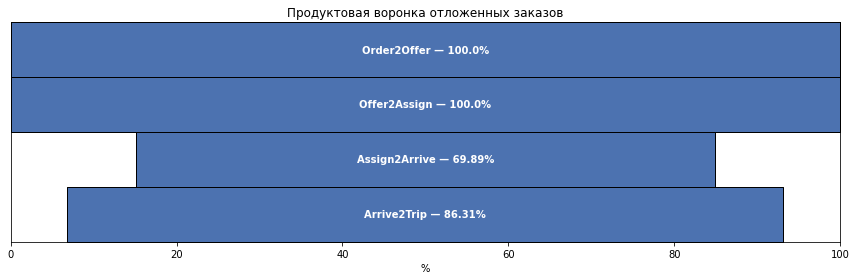

In [420]:
steps = ["Order2Offer", "Offer2Assign", "Assign2Arrive", "Arrive2Trip"]

df_steps = post_metrics.loc[steps]

fig, ax = plt.subplots(figsize=(12, 4))
max_width = 100
n = len(df_steps)
color = "#4C72B0"

for i, step in enumerate(df_steps.index):
    value = post_metrics.loc[step, "%"]  # процент для ширины сегмента
    y_top = n - i - 1
    y_bottom = y_top + 1

    ax.fill_betweenx(
        [y_top, y_bottom],
        (max_width - value) / 2,
        (max_width + value) / 2,
        color=color,
        edgecolor='black',
        linewidth=1
    )

    ax.text(
        max_width / 2,
        y_top + 0.5,
        f"{steps[i]} — {value}%",
        ha="center",
        va="center",
        color="white",
        fontsize=10,
        fontweight="bold")

ax.set_xlim(0, max_width)
ax.set_ylim(0, n)
ax.set_yticks([])
ax.set_xlabel('%')
ax.set_title("Продуктовая воронка отложенных заказов")
plt.tight_layout()
plt.show()

Строю график главной конверсии отложенных заказов

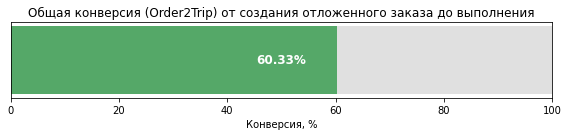

In [421]:
value = post_metrics.loc["Order2Trip", "%"]

fig, ax = plt.subplots(figsize=(8, 2))

ax.barh(0, 100, color="#e0e0e0", height=0.5)

ax.barh(0, value, color="#55A868", height=0.5)

ax.text(50, 0, f"{value}%", ha="center", va="center", color="white", fontsize=12, fontweight="bold")

ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_xlabel("Конверсия, %")
ax.set_title("Общая конверсия (Order2Trip) от создания отложенного заказа до выполнения")

plt.tight_layout()
plt.show()

Строю график времени выполнения каждого этапа отложенных заказов

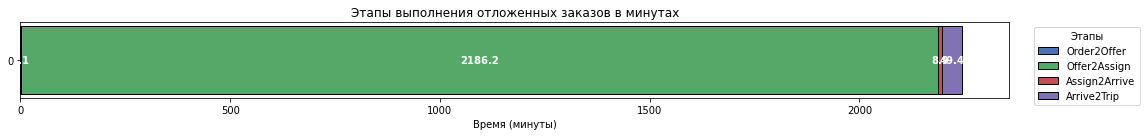

In [422]:
# Шаги воронки
time_steps = ["Order2Offer", "Offer2Assign", "Assign2Arrive", "Arrive2Trip"]
df_funnel = post_metrics.loc[time_steps]

fig, ax = plt.subplots(figsize=(16, 2))

y = [0]  
left = 0  

colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"] 
for i, step in enumerate(df_funnel.index):
    width = df_funnel.loc[step, "time_mins"]
    bar = ax.barh(y, width, left=left, color=colors[i], edgecolor="black")
    
    ax.text(left + width/2, y[0], f"{width:.1f}",
            ha="center", va="center", color="white", fontsize=10, fontweight="bold")
    
    left += width  

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], edgecolor="black", label=step) 
                   for i, step in enumerate(df_funnel.index)]
ax.legend(handles=legend_elements, title="Этапы", bbox_to_anchor=(1.02, 1), loc="upper left")

ax.set_yticks([0])
ax.set_xlabel("Время (минуты)")
ax.set_title("Этапы выполнения отложенных заказов в минутах")
ax.invert_yaxis() 
plt.tight_layout()
plt.show()

Всего отложенных заказов

In [423]:
post_count = df_ab_post.time_order.notna().sum()
post_count

920

Выполненных отложенных заказов

In [424]:
post_end_trip = df_ab_post.trip_time.notna().sum()
post_end_trip

555

Доля отложенных заказов среди всех заказов (тестовой группы) в процентах

In [425]:
round(post_count/(post_count+test_count)*100,2)

13.95

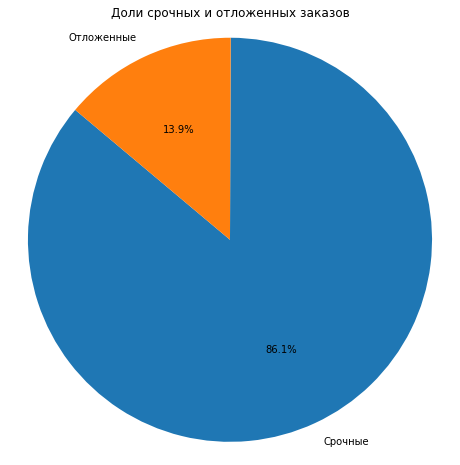

In [426]:
values = [test_count, post_count]
labels = ['Срочные', 'Отложенные']

# строим круговую диаграмму
fig, ax = plt.subplots(figsize=(8,8))
ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
ax.axis('equal')
ax.set_title("Доли срочных и отложенных заказов")
plt.show()

Сравню общии конверсии срочных и отложенных заказов. Проведу z-test. Нулевая гипотеза: конверсии в группах не различаются

In [427]:
# конверсии групп
p_post = post_end_trip / post_count
p_test = test_end_trip / test_count

# общая конверсия
p_pool = (post_end_trip + test_end_trip) / (post_count + test_count)

# стандартная ошибка
se = sqrt(p_pool * (1 - p_pool) * (1/post_count + 1/test_count))

# z-статистика
z = (p_test - p_post) / se
p_value = 2 * (1 - norm.cdf(abs(z)))

print('Z-score = ',z)
print('p-value = ',p_value)

Z-score =  -1.5834176914962488
p-value =  0.11332629325883303


Вывод: p-value > 0.05, принимаю гипотезу о равенстве конверсий. Срочные и отложенные заказы имеют одинаковые шанс на успешное выполнение.

Рассмотрю метрику Assign2Arrive = 69.89 %. У отложенных заказов она просела еще больше.

In [428]:
df_ab_post_ = df_ab_post.dropna(subset=['Order2Arrive_time'])

Строю графики времени ожидания приезда водителя на первую точку отложенных заказов

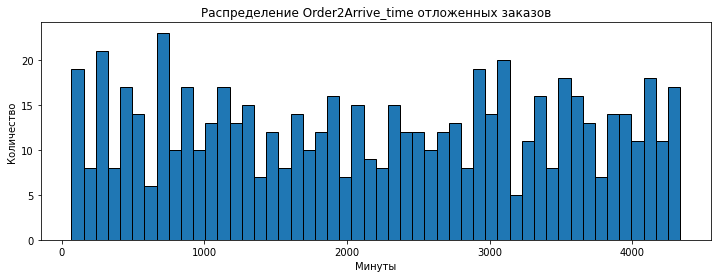

In [429]:
plt.figure(figsize=(12,4))
plt.hist(df_ab_post_['Order2Arrive_time'], bins=50, edgecolor='black')
plt.xlabel('Минуты')
plt.ylabel('Количество')
plt.title('Распределение Order2Arrive_time отложенных заказов')
plt.show()

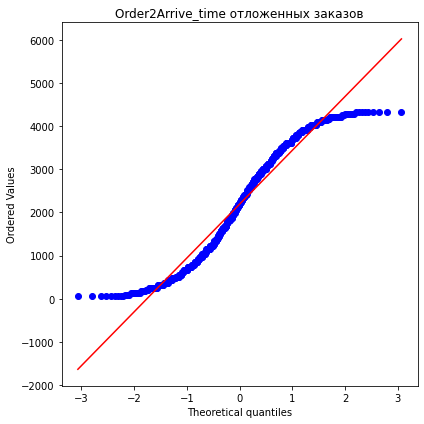

In [430]:
data = df_ab_post_["Order2Arrive_time"].dropna()

plt.figure(figsize=(6, 6))
stats.probplot(data, dist="norm", plot=plt)
plt.title("Order2Arrive_time отложенных заказов")
plt.tight_layout()
plt.show()

Проведу тест Шапиро-Уилка.  Нулевая гипотеза: распределение в группах нормальные

In [431]:
stat_c, p_c = shapiro(df_ab_post_.Order2Arrive_time)

print('Отложенные заказы: s=',stat_c,'p=', p_c)

Отложенные заказы: s= 0.9470140933990479 p= 2.1058267366739873e-14


Вывод: распределение не является нормальным

Теперь проведу тест на равенство дисперсий времени ожидания приезда машины на первый адрес срочных и отложенных заказов, буду использовать тест Левена. Нулевая гипотеза: дисперсии в группах равные

In [432]:
stat_var, p_var = levene(df_ab_test_.Order2Arrive_time, df_ab_post_.Order2Arrive_time)

print('Сравнения групп: s=',stat_var,'p-value=', p_var)

Сравнения групп: s= 11058.747942147289 p-value= 0.0


Вывод: дисперсии не равны

Теперь я сравню величны в двух группах с помощью критерия Манна-Уитни. Нулевая гипотеза: распределения в срочных и отложенных заказов одинаковые

In [433]:
post = df_ab_post_["Order2Arrive_time"].dropna()
test = df_ab_test_["Order2Arrive_time"].dropna()

u_stat, p_value = mannwhitneyu(
    control,
    test,
    alternative="two-sided"
)

print('Статистика:', u_stat, 'p-value:', p_value)

Статистика: 4079551.0 p-value: 1.928011692966388e-142


Вывод: тест показал разницу между группами. Метрика Order2Arrive действительно упала в отложенных заказах.

Теперь я хочу сравнить конверсии предложений заказов водителям в срочных и отложенных заказах. В срочных заказах  88.34%, в отложенных 100%.

In [434]:
post_offer = df_ab_post.time_offer.notna().sum()

In [435]:
# конверсии групп
p_post = post_offer / post_count
p_test = test_offer / test_count

# общая конверсия
p_pool = (post_offer + test_offer) / (post_count + test_count)

# стандартная ошибка
se = sqrt(p_pool * (1 - p_pool) * (1/post_count + 1/test_count))

# z-статистика
z = (p_test - p_post) / se
p_value = 2 * (1 - norm.cdf(abs(z)))

print('Z-score = ',z)
print('p-value = ',p_value)

Z-score =  -10.920093117175057
p-value =  0.0


Вывод: конверсии различаются. В срочных заказах шанс найти водителя действительно меньше чем в отложенных.

**Общий вывод: доля отложенных заказов 13%. Главные конверсии отложенных и срочных заказов не отличаются. Все 100% отложенных заказов получают назначения водителей, однако доля заказов в которых водители доедут до первой точки ниже чем у срочных заказов, 69% против 76%. 31% водителей на отложенных заказах просто не выполняют заказ после того как согласились на его выполнение. На срочных заказах таких водителей только 12%**

---